In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import pathlib

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 3]
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.autolayout'] = True

font = {'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.use("pgf")

import os
import sys
os.chdir('..')
sys.path.insert(0, '..')

from trlfpi.report import Report

In [2]:
def importExperimentData(experimentNames):
    experiments = []
    rewards = []
    eval_rewards = []
    test_rewards = []
    actor_loss = []
    critic_loss = []
    for path, name in experimentNames:
        
        report = Report(f"./results/{path}")
        for i in report.listExisting():
            report.id(i)
            variables = report.unpickle('variables')
            rewards.append(variables['reward'][0])
            eval_rewards.append(variables['eval_reward'])
            actor_loss.append(variables['actor_loss'][0])
            critic_loss.append(variables['critic_loss'][0])
            test_rewards.append(variables['test_reward'][0])
            experiments.append({
                'name': name,
                'iteration': i
            })
    i = pd.Index(range(1, 5001))
    nI = pd.Index(range(30))
    evalRewardsDF = pd.concat([pd.DataFrame({idx: x[0]}, index=x[1]).reindex(i).T for idx, x in enumerate(eval_rewards)], axis=0)
    
    dfs = list(map(lambda x: pd.DataFrame(x), [experiments, rewards, test_rewards, actor_loss, critic_loss]))
    dfs.append(evalRewardsDF)
    return dfs

In [3]:
expDF, rewardDF, testRewardDF, actorDF, criticDF, evalRewardsDF = importExperimentData([('clutchAC_b_h2', 'AC'),
                                                                                       ('clutchDPG_b_h2', 'DPG'),
                                                                                       ('clutchPPO_b_h2', 'PPO'), 
                                                                                       ('clutchMBACD_b_h2', 'MBACD')])

In [4]:
rDF = pd.concat([expDF, rewardDF], axis=1, join='inner').drop(['iteration'], axis=1)
cDF = pd.concat([expDF, criticDF], axis=1, join='inner').drop(['iteration'], axis=1)

In [5]:
# AC plots
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
axs[0].plot(rDF[rDF['name'] == 'AC'].drop(['name'], axis=1).T)
axs[0].set_ylim((-50000, 5))
axs[0].set_title('Reward')
axs[0].grid()
axs[1].plot(cDF[cDF['name'] == 'AC'].drop(['name'], axis=1).T)
axs[1].set_ylim((0, 100000000))
axs[1].set_title('Critic Cost')
axs[1].grid()
plt.savefig('plots/AC.pgf')

In [6]:
# DPG plots
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
axs[0].plot(rDF[rDF['name'] == 'DPG'].drop(['name'], axis=1).T)
axs[0].set_ylim((-1000, 5))
axs[0].set_title('Reward')
axs[0].grid()
axs[1].plot(cDF[cDF['name'] == 'DPG'].drop(['name'], axis=1).T)
axs[1].set_ylim((0, 50000))
axs[1].set_title('Critic Cost')
axs[1].grid()
plt.savefig('plots/DPG.pgf')

In [7]:
# PPO plots
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
axs[0].plot(rDF[rDF['name'] == 'PPO'].drop(['name'], axis=1).T)
axs[0].set_ylim((-200, 5))
axs[0].set_title('Reward')
axs[0].grid()
axs[1].plot(cDF[cDF['name'] == 'PPO'].drop(['name'], axis=1).T)
axs[1].set_ylim((0, 100))
axs[1].set_title('Critic Cost')
axs[1].grid()
plt.savefig('plots/PPO.pgf')

In [8]:
# MBACD plots
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
axs[0].plot(rDF[rDF['name'] == 'MBACD'].drop(['name'], axis=1).T)
axs[0].set_title('Reward')
axs[0].grid()
axs[1].plot(cDF[cDF['name'] == 'MBACD'].drop(['name'], axis=1).T)
axs[1].set_title('Critic Cost')
axs[1].grid()
plt.savefig('plots/MBACD.pgf')

In [9]:
compTableDF = expDF.groupby('name').mean().drop(['iteration'], axis=1)
compTableDF['mean'] =  pd.concat([expDF, testRewardDF], axis=1, join='inner').groupby('name').mean().drop(['iteration'], axis=1).mean(axis=1)
compTableDF['std'] = pd.concat([expDF, testRewardDF], axis=1, join='inner').groupby('name').mean().drop(['iteration'], axis=1).std(axis=1)
print(compTableDF.to_latex())

\begin{tabular}{lrr}
\toprule
{} &          mean &          std \\
name  &               &              \\
\midrule
AC    & -7.962807e+03 &    48.412595 \\
DPG   & -1.082290e+00 &     0.193260 \\
MBACD & -1.055485e+07 &  3760.592883 \\
PPO   & -9.125897e-01 &     0.170127 \\
\bottomrule
\end{tabular}



# PPO with Future Inputs

In [35]:
expDF, rewardDF, testRewardDF, actorDF, criticDF, evalRewardDF = importExperimentData([
      ('0_PPO_s_h3', 'PPO'),
      ('0_DPPO_s_h3', 'DPPO'),
      ('0_MAPPO_s_h3', 'MAPPO'),
      ('1_PPO_s_h3', 'PPO'),
      ('1_DPPO_s_h3', 'DPPO'),
      ('1_MAPPO_s_h3', 'MAPPO')
])

rDF = pd.concat([expDF, rewardDF], axis=1, join='inner').drop(['iteration'], axis=1)
erDF = pd.concat([expDF, evalRewardDF], axis=1, join='inner').drop(['iteration'], axis=1)
cDF = pd.concat([expDF, criticDF], axis=1, join='inner').drop(['iteration'], axis=1)
expDF['bestEvalEp'] = erDF.drop('name', axis=1).T.idxmax()
compTableDF = expDF.groupby('name').mean().drop(['iteration'], axis=1)
compTableDF['rewardMean'] =  pd.concat([expDF, testRewardDF], axis=1, join='inner').groupby('name').mean().drop(['iteration', 'bestEvalEp'], axis=1).mean(axis=1)
compTableDF['rewardStd'] = pd.concat([expDF, testRewardDF], axis=1, join='inner').groupby('name').mean().drop(['iteration', 'bestEvalEp'], axis=1).std(axis=1)
compTableDF['bestEvalEpStd'] = expDF.groupby('name').std().drop(['iteration'], axis=1)
compTableDF

,bestEvalEp,rewardMean,rewardStd,bestEvalEpStd
name,,,,
DPPO,1504.0,-1.134777,0.255765,1268.517945
MAPPO,1966.0,-0.940591,0.291078,1771.115154
PPO,979.0,-3.799676,0.570555,752.543096


## Evaluation plot

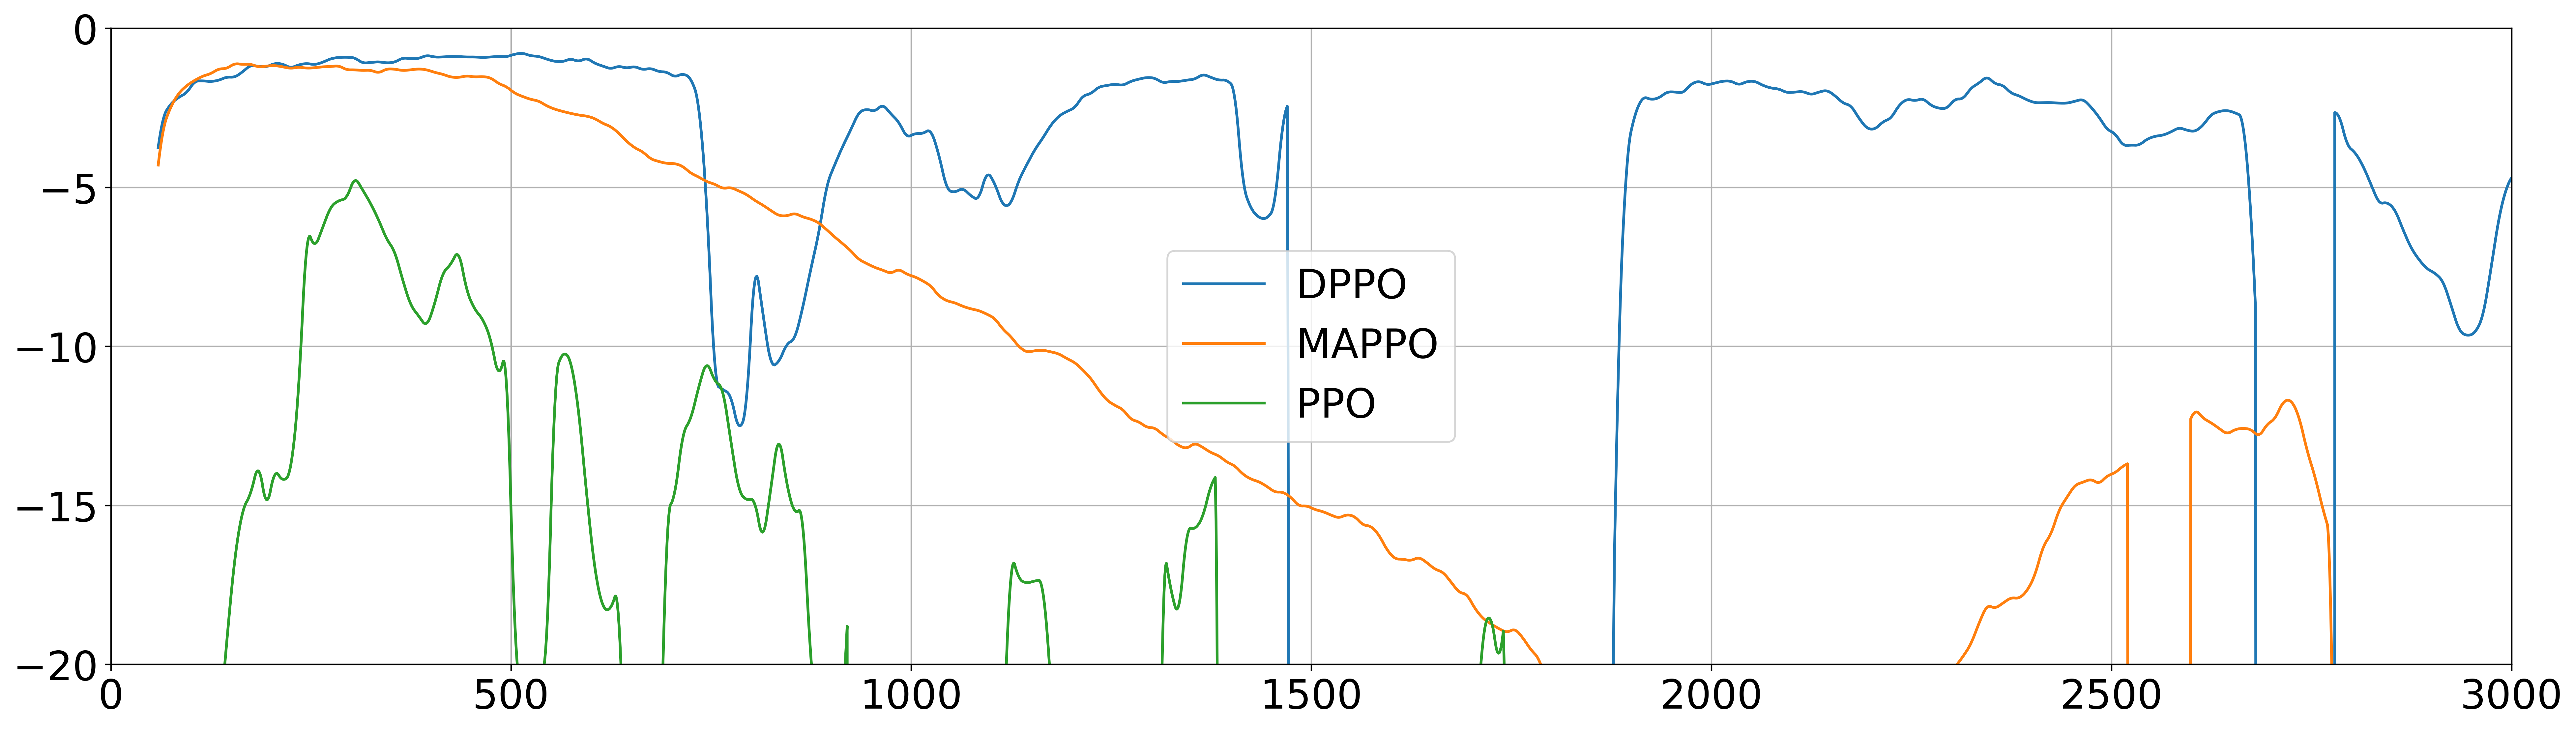

In [43]:
meanDF = pd.concat([expDF, evalRewardDF], axis=1, join='inner').groupby('name').mean().drop(['iteration', 'bestEvalEp'], axis=1)
stdDF = pd.concat([expDF, evalRewardDF], axis=1, join='inner').groupby('name').std().drop(['iteration', 'bestEvalEp'], axis=1)
fig = plt.figure(figsize=(20, 6))
plt.plot(meanDF.T.interpolate(method='linear').rolling(50).mean())
plt.xlim((0, 3e3))
plt.ylim((-2e1, 0))
plt.legend(['DPPO', 'MAPPO', 'PPO'])
plt.grid()
fig

## Training cost

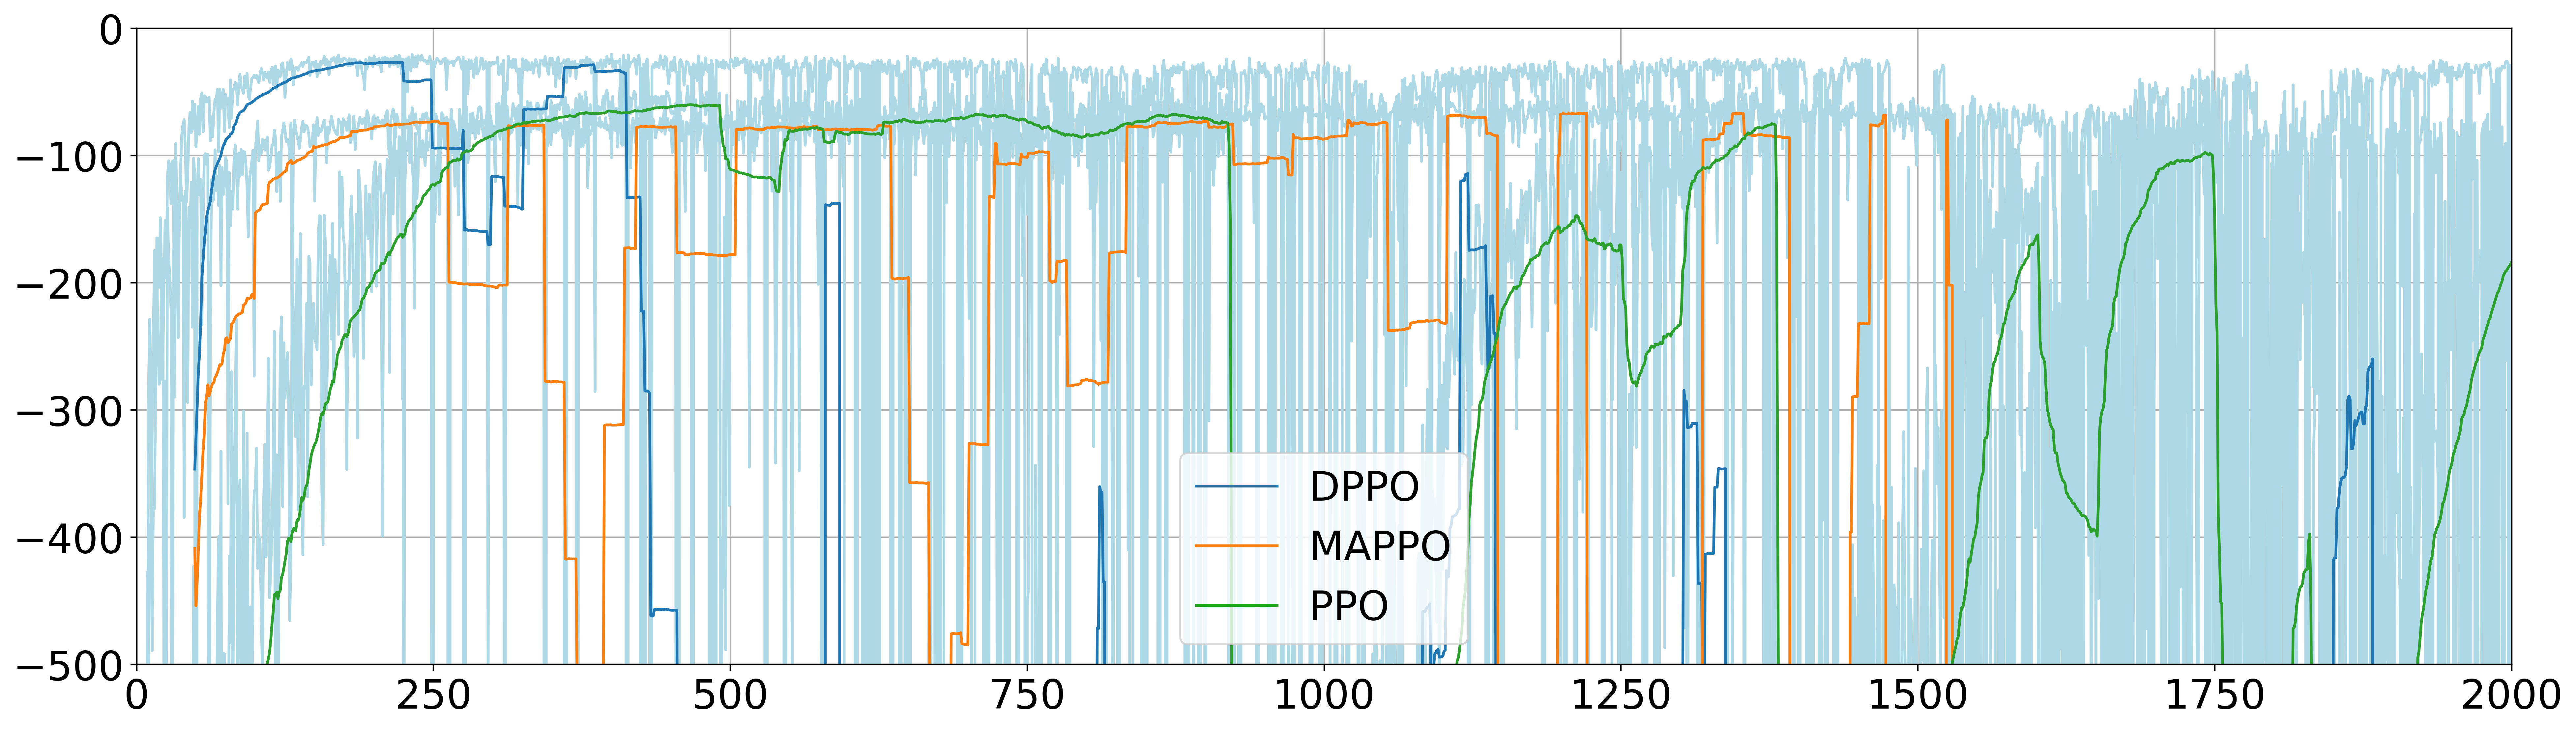

In [44]:
meanDF = pd.concat([expDF, rewardDF], axis=1, join='inner').groupby('name').mean().drop(['iteration', 'bestEvalEp'], axis=1)
stdDF = pd.concat([expDF, rewardDF], axis=1, join='inner').groupby('name').std().drop(['iteration', 'bestEvalEp'], axis=1)
fig = plt.figure(figsize=(20, 6))
plt.plot(meanDF.T, 'lightblue', label='_nolegend_')
plt.plot( meanDF.T.rolling(50).mean())
plt.xlim((0, 2e3))
plt.ylim((-5e2, 0))
plt.legend(['DPPO', 'MAPPO', 'PPO'])
plt.grid()
fig